# N01. Proyección (predicción) del MEI (Índice Multivariado El Niño)
Para leer los datos del MEI se pueden descargar desde el siguiente enlace:
https://psl.noaa.gov/enso/mei/data/meiv2.data


## 1. Descarga, salva y grafica los índices MEI históricos
Se descargan los índices MEI históricos de "https://psl.noaa.gov/enso/mei/data/meiv2.data".

In [3]:
#*******************************************************************************       
# 1.1. Carga paquetes Python requeridos.
#*******************************************************************************
import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import matplotlib.pyplot as plt
%matplotlib widget
#pd.options.plotting.backend = "plotly"

import seaborn as sns

In [4]:
#*******************************************************************************
# 1.2. Descarga el archivo de índices MEI y lo salva.
#*******************************************************************************
# 1.2.1. Importa la librería requests
import requests
URL = "https://psl.noaa.gov/enso/mei/data/meiv2.data"
# 1.2.2. Descarga el dato en el URL.
response = requests.get(URL)
# 1.2.3. Salva la respuesta en un nuevo archivo llamado meiv2.txt
open("csv/meiv2.csv", "wb").write(response.content)
#*******************************************************************************
meiA = pd.read_csv("csv/meiv2.csv", delim_whitespace=True, skiprows=1, 
                  skipfooter=4, engine='python', names=['anio', '01', '02', 
                  '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])
#*******************************************************************************
meiL = pd.melt(meiA, id_vars= ["anio"],
              value_vars= ["01", "02", "03", "04", "05", "06", "07", "08", 
                       "09", "10", "11", "12"], 
                       var_name="bimes", value_name='mei'
        )
#*******************************************************************************
meiL['anio'] = meiL['anio'].apply(str)
meiL["anioMes"] = meiL['anio'] + "-" + meiL['bimes'] + "-01 00:00:00"
meiL["anioMes"] = pd.to_datetime(meiL["anioMes"])
meiL = meiL.set_index("anioMes")
meiL = meiL.loc[:, ["mei"]]
meiL = meiL.sort_index()
meiL = meiL[meiL['mei']!=-999.00]
#*******************************************************************************
#1.2.4. Salva el meiL en formato parquet. Es más comprimido y mantiene formatos.
#meiL.to_csv("csv/meiL.csv")
meiL.to_parquet("parquet/meiL.parquet.gzip", compression='gzip') 

In [65]:
#*******************************************************************************
# 1.3. Lee el archivo meiL que está en formato parquet.
#*******************************************************************************
meiL = pd.read_parquet('parquet/meiL.parquet.gzip')

In [71]:
#meiL.tail(20)
# meiL.index = pd.to_datetime(meiL.index).to_period('M')
# meiL['etiquetaX'] = meiL.index
# meiL['etiquetaX'] = np.where(meiL['etiquetaX'].astype(str).\
#     str.slice(5, 7) == '01', meiL['etiquetaX'].astype(str).str.slice(0, 4)\
#         , '')

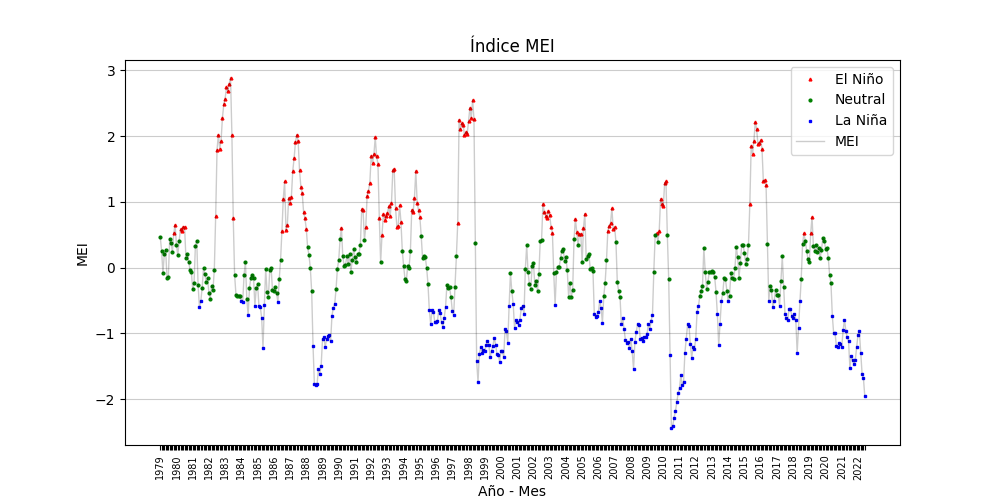

In [92]:
#*******************************************************************************
# 1.4. Grafica los índices meiL.
#*******************************************************************************
#meiL.plot()
ind = np.arange(522)
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
#p1 = ax1(ind, eventosSTRCausaTotal.values)
ax1.set_title ('Índice MEI')
ax1.set_ylabel ('MEI')
ax1.set_xlabel ('Año - Mes')
ax1.set_xticks(ind, labels=meiL.etiquetaX, rotation=90, fontsize=7)
#plt.xticks(rotation=90)
#
superior = 0.5
inferior = -0.5
nino = np.ma.masked_where(meiL.mei < superior, meiL.mei) #La máscara borra dato.
nina = np.ma.masked_where(meiL.mei > inferior, meiL.mei)
neutral = np.ma.masked_where((meiL.mei <= inferior) | (meiL.mei >= superior), meiL.mei)
ax1.plot(ind, nino, 'r^', label='El Niño', markersize=2)
ax1.plot(ind, neutral, 'go', label='Neutral', markersize=2)
ax1.plot(ind, nina, 'bs', label='La Niña', markersize=2)
ax1.plot(ind, meiL.mei, 'k-', label='MEI', linewidth=1, alpha=0.2)
plt.legend(loc='best')
plt.grid(axis='y', color='k', alpha=0.2)
plt.show()

## 2. Proyecta los índices MEI
Se cuenta con 522 datos de MEI mensuales (bimensuales). Se desean proyectar los valores de MEI para los 6 meses de 2022 y para los 72 meses de los próximos seis años, hasta diciembre de 2028. En total se desea hacer la proyección de 78 meses.
Por eso, los índices de los primeros 444 meses conformarán el conjunto de 'train' (entrenamiento) y los datos de los últimos 78 meses constituirán el conjunto de 'test' (prueba). 

In [102]:
train = meiL.iloc[0:-78, 0] # Los primeros 444 meses.
test = meiL.iloc[-78:, 0] # Los últimos 78 meses.


In [104]:
test

anioMes
2016-01    1.94
2016-02    1.81
2016-03    1.31
2016-04    1.33
2016-05    1.26
           ... 
2022-02   -0.97
2022-03   -1.30
2022-04   -1.61
2022-05   -1.68
2022-06   -1.95
Freq: M, Name: mei, Length: 78, dtype: float64